# Notebook to run the gaussian regularized alghorithms 

In [245]:


from prob_models.utils.utils import read_paths, getdata

# read_add_paths('paths.txt')
# paths = read_paths('paths.txt')

import prob_models.cov_estim.estimators as es 
import prob_models.cov_estim.run_parallel as run
from prob_models.cov_estim.utils import *
import numpy as np
import os
import importlib
import matplotlib.pyplot as plt
import pickle
import sys
from pyvis.network import Network
import pandas as pd

importlib.reload(run)
import networkx as nx
import scipy.sparse.csgraph as grp  
from nichord.glassbrain import plot_glassbrain

mod = importlib.reload(sys.modules['prob_models.utils.utils'])#use imp.reload for Python 3  
vars().update(mod.__dict__)

#importlib.reload(prob_models.utils.utils)


In [117]:
# Load data 
paths = read_paths(os.path.join(os.getcwd(), '../paths.txt'))
datadic = getdata(paths,dataset='CamCAN')
T, N = np.shape(list(datadic.values())[0])
print (T,N)


261 114


In [121]:

train_fraction = 0.8
if 'results' not in globals():
    results={}
    TrainTest={}
    
for i,( key, X) in enumerate(datadic.items()):
    if (i<20) & (i not in results):
        print (i)
        # Compute the corr mat C obtained flattening the training data from all patients
        Cbar = computeCbar([el for el in datadic.values()], train_fraction=train_fraction)
        Xtrain, Xtest = split_train_test(X, train_fraction=train_fraction, standardize=True, seed=i)
        TrainTest[key]={'train':Xtrain,'test':Xtest} #save train and test
        key,value=run.single_run(i, Xtrain, Xtest, Cbar=Cbar)
        


        #adding Raw estimator
        J = np.linalg.inv(np.corrcoef(Xtrain.T))
        te_lik=impl.likelihood_set_fast(J, Xtest)    
        tr_lik=impl.likelihood_set_fast(J, Xtrain)
        value['Raw']={'test_likelihood':te_lik,
                      'train_likelihood':tr_lik}
        
        results[key]=value



10
11
12
13
14
15
16
17
18
19


In [ ]:
#savefile
filename='../savedfiles/file_TrainTest.pkl'
file = open(filename, "wb")
pickle.dump(TrainTest, file)
file.close()

filename='../savedfiles/file_Gaussianresults.pkl'
file = open(filename, "wb")
pickle.dump(results, file)
file.close()

filename=folder+'file_'+file_+'.pkl'
file = open(filename, "rb")
loaded=pickle.load(file)
file.close()


# producing the boxplots from the saved results


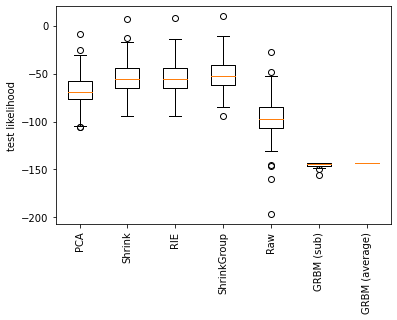

In [ ]:


# file = open(filename, "rb")
# results=pickle.load(file)
# file.close()

filename='../savedfiles/file_Gaussianresults.pkl'
file = open(filename, "rb")
results=pickle.load(file)
file.close()

filename='../savedfiles/all_subs_likelihood.csv'
this=pd.read_csv(filename) 



data={}
results
for subno,sub in results.items():   
    for meth,val in sub.items():
        if meth not in data:
            data[meth]=[]
        data[meth].append(val['test_likelihood'])


filename='../results/results.csv'
this=pd.read_csv(filename) 
data['GRBM (sub)']=this.ll_test
data['GRBM (average)']=this.ll_test[49]





#     data[key]=[results[subno]['test_likelihood'] for subno in results.keys()]
# print (data)
labels, data = data.keys(), data.values()
labels=[el.split('_')[0] for el in labels]


plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels,rotation='vertical')
plt.ylabel('test likelihood')
plt.savefig('likelihoods_methods.png')
plt.show()

# visualization of graphs

In [215]:
def percolazione(matrix,graph=True,abs=True): #restituisce il grafo della matrice M sogliato secondo tale criterio
    '''Applies the percolation threshold to matrix'''
    M=np.copy(matrix)

    s=soglia_perc(np.abs(M))
    ind=np.where(np.abs(M)<s)

    M[ind]=0
    if graph:
        return  nx.from_numpy_matrix(np.abs(M))
    elif abs:
        return np.abs(M)
    else:
        return M

def soglia_perc(matrix):
    ''' Returns the percolation threshold of matrix, taken in absolute value
    '''
    soglia_=0
    M=np.abs(np.copy(matrix))
    lista=np.unique(M) #ordina gli elementi della matrice, senza ripetizioni
    S=len(lista)-1
    
    if len(lista)>1000:  #parto da qui se la lista è più lunga di 1000
        for i in range(int(len(lista)/1000)): #scorre dal basso all'alto, ad intervalli di 1000

            j=i*1000
            ele= lista[j]

            indici=np.where( M < ele )
            M[indici]=0   
            cc=grp.connected_components(M, directed=False, return_labels=False)

            if  cc>1:

                S=j
                #print (i,cc, ele,'inverti') #indice 
                break
    
    if len(lista)>100: #parto da qui se la lista è più lunga di 100
        for i in range(int(S/100)): #scorre dall'alto al basso, a passi di 100
            M=np.abs(np.copy(matrix))
            ele= lista[S-i*100]
        #print (ele)
            indici=np.where( M < ele )
            M[indici]=0   
            cc=grp.connected_components(M, directed=False, return_labels=False)
            #print (cc)
            if  cc<2:
                S=S-i*100
                break
    
    if len(lista)>10: #parto da qui se la lista è più lunga di 10
        for i in range(int(S/10)): #scorre dal basso all'alto, a passi di 10
            M=np.abs(np.copy(matrix))
            ele= lista[S+i*10]
            #print (ele)
            indici=np.where( M < ele )
            M[indici]=0   
            cc=grp.connected_components(M, directed=False, return_labels=False)
            #print (cc)
            if  cc>=2:

                S=S+i*10
                #print ('inverti')
                break
    
    #questa la esegue sempre    
    for i in range(int(S)): #scorre dall'alto al basso, eleemnto per elemento 
        M=np.abs(np.copy(matrix))
        ele= lista[S-i]
    #print ('ele',ele)
        indici=np.where( M < ele )
        M[indici]=0   
        cc=grp.connected_components(M, directed=False, return_labels=False)
        #print (cc)
        if  cc<=1:
            soglia_=ele
            #print ('fine',soglia_J)
            break
    return soglia_


def standarise(M,thisax=0): 
    '''
    standardizes M along given axis
    '''
    Ms=np.copy(M)
    Ms-=np.average(Ms,axis=thisax)
    Ms/=np.std(Ms,axis=thisax)
    return Ms    

def removeselfloops(matrix):
    M=matrix.copy()
    return M -np.eye(len(M))*np.diag(M) 

def zones(n):
   
    if n in set(range(28)):#Lobo frontale
        return ('Frontal')

    if n in set(range(68,70)):#Lobo frontale
        return ('Frontal')

    if n in set(range(28,30)):#Insula
        return ('Insula')

    if n in set(range(30,36)):#Corteccia cingolata
        return ('Cingulate cortex')

    if n in set([38,39,54,55]):#Lobo temporale
        return ('Temporal')

    if n in set(range(78,90)):#Lobo temporale
        return ('Temporal')

    if n in set(range(42,54)):#Lobo occipitale
        return ('Occipital')

    if n in set(range(56,68)):#Lobo parietale
        return ('Parietal')

    if n in set([36,37,40,41]):#sostanza grigia profonda
        return ('Deep gray matter')

    if n in set(range(70,78)):#sostanza grigia profonda
        return  ('Deep gray matter')

    if n in set(range(90,110)):#cervelletto
        return ('Cerebellum')
    if n in set(range(110,116)):#verme cervelletto
        return ('Cerebellum vermis')
    
brain_zone_color={}
brain_zone_color['Frontal']='cyan'
brain_zone_color['Insula']='yellow'
brain_zone_color['Cingulate cortex']='red'
brain_zone_color['Temporal']='pink'
brain_zone_color['Occipital']='violet'
brain_zone_color['Parietal']='orange'
brain_zone_color['Deep gray matter']='olive' #Deep gray matter and Subcortical seem to coincide to me
brain_zone_color['Subcortical']='olive'
brain_zone_color['Cerebellum']='silver'
brain_zone_color['Cerebellum vermis']='grey'


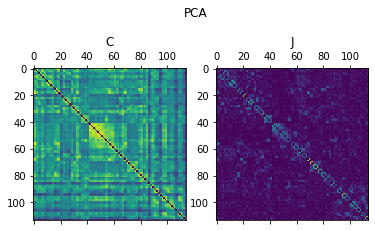

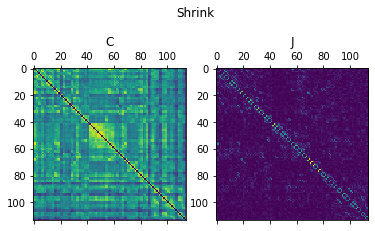

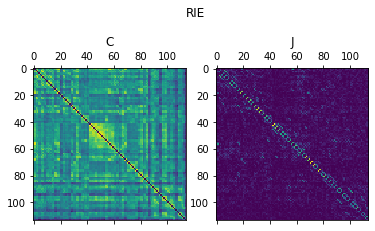

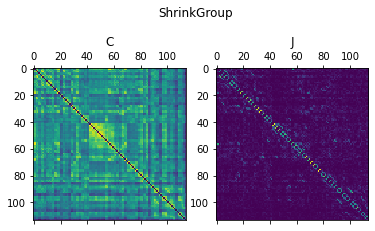

In [ ]:
#Gaussian Model:  visualize the correlation and precision matrices inferred with regularization 
for key in results[0].keys():
    if key!='Raw':
        Cgauss=np.abs(removeselfloops(np.median([el[key]['Cclean'] for el in results.values()],axis=0)))
        Jgauss=np.abs(removeselfloops(np.median([standarise(np.linalg.pinv(el[key]['Cclean'])) for el in results.values()],axis=0)))

        fig,ax=plt.subplots(ncols=2)
        i=0
        ax[i].matshow(Cgauss)
        ax[i].set_title('C')
        i=1
        ax[i].matshow(Jgauss)
        ax[i].set_title('J')
        fig.suptitle(key.split('_')[0])

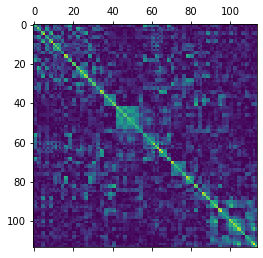

In [ ]:
#pyvis plot of the J or of the GRBM
fs=20
idx_to_label={key:zones(key) for key in range(114)}
i=80
soglia= False
Gauss=False
GRBM=True



if GRBM:
    W=np.load('../results/params2_80.npy')
    Jeff=np.abs(W@W.T)
    Adj=np.copy(Jeff)

if Gauss:
    Cgauss=(np.median([el['Shrink_CV_likelihood']['Cclean'] for el in results.values()],axis=0))
    Cgauss-=np.eye(len(Cgauss))*np.diag(Cgauss)

    Jgauss=np.median([standarise(np.linalg.pinv(el['Shrink_CV_likelihood']['Cclean'])) for el in results.values()],axis=0)
    Jgauss-=np.eye(len(Jgauss))*np.diag(Jgauss)
    Adj=np.copy(Jgauss)

plt.matshow(np.abs(Adj))

if soglia:
    M=np.abs(np.copy(Adj))
    indici=np.where(np.abs(M)<soglia)
    for el in zip(indici[0],indici[1]):    
        M[el]=0. 
    indici=np.where(np.abs(M)>0)
    G=nx.from_numpy_matrix(M)
    
else:
    G=percolazione(Adj,graph=True)


G.remove_edges_from(nx.selfloop_edges(G))
nt = Network('600px', '900px',notebook=False,heading='RGBM'+str(i))


nx.set_node_attributes(G,{key:brain_zone_color[val] for key, val in idx_to_label.items()},'color') 
nx.set_node_attributes(G,5,'label_size') 
nx.set_node_attributes(G,'solid','shape') 
nx.set_edge_attributes(G,'black','color') # Edge color
nx.set_edge_attributes(G,{(el[0],el[1]): el[2]['weight']*10 for el  in G.edges(data=True)},'width') # Edge width



nt.from_nx(G)
for n in nt.nodes:
    n["font"]={"size": fs}
    n["size"] = 0.05*fs
    
nt.barnes_hut()
nt.toggle_physics(True)

nt.repulsion(node_distance=2*np.sum([el[2]['weight']**2 for el  in G.edges(data=True)]), central_gravity=0.0, 
                spring_length=2*np.sum([el[2]['weight']**2 for el  in G.edges(data=True)]), spring_strength=0.05, damping=0.09)
nt.show('Hg.html') 



    # nx.draw_networkx(G,pos=nx.kamada_kawai_layout(G,weight='weight'),node_color=[brain_zone_color[val] for key, val in idx_to_label.items()], with_labels=True)
    # plt.title('Average $J^-1$, a= '+str(a)+', '+ds ,size=20)
    # plt.subplots_adjust(top=0.80,wspace=0)
    # plt.savefig('savedfig/average_J'+str(a)+ds+'.pdf')


In [282]:
from nilearn import plotting
#also brain plot
coords = pd.read_excel('../coords_aal.xls')
thesecoords2=list(zip(coords['X_MNI'],coords['Y_MNI'],coords['Z_MNI']))
thesecoords=(list(map(lambda tuple:[float(val.replace('−', '-')) for val in tuple],thesecoords2)))
#filename='RBM_brain'
filename=None

plot_glassbrain(idx_to_label, edges=G.edges(), edge_weights=[el[2]['weight']*20 for el in G.edges(data=True)],
                fp_glass=filename, coords=thesecoords, network_colors=brain_zone_color, linewidths=5, node_size=10,
                cmap=plt.get_cmap('Blues'),vmin=0)

